In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
import numpy as np
import os

In [3]:
# Unzipping the file
!unzip -q '/content/drive/My Drive/gem_data.zip' -d '/content/gem_data/'

# Check the contents
os.listdir('/content/gem_data/')


['test', 'train']

In [4]:
train_dir = '/content/gem_data/train'
test_dir = '/content/gem_data/test'


In [14]:
batch_size = 32
image_size = (224, 224)

# Training data augmentation with additional augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.4,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    brightness_range=[0.7, 1.3],  # Adjust brightness
    horizontal_flip=True,
    fill_mode='nearest'
)

# Test data generator (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 2856 images belonging to 87 classes.
Found 363 images belonging to 87 classes.


In [15]:
# Load the pre-trained MobileNetV2 model with weights from ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [17]:
# Extract class indices from the training generator
classes = train_generator.classes  # This gives the class indices for all images

# Get the class labels and the number of classes
class_labels = list(train_generator.class_indices.keys())

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),  # This is the unique classes from the generator
    y=classes  # The labels for all the images
)

# Convert the output to a dictionary for Keras
class_weights = dict(enumerate(class_weights))


In [18]:
# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)


In [19]:
epochs = 70

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=epochs,
    class_weight=class_weights,  # Use class weights to balance the classes
    callbacks=[early_stopping, lr_reduction]
)


Epoch 1/70


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 56s 498ms/step - accuracy: 0.0296 - loss: 4.6712 - val_accuracy: 0.1903 - val_loss: 3.8122 - learning_rate: 1.0000e-04
Epoch 2/70
 1/89 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.0938 - loss: 4.1034

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0938 - loss: 4.1034 - val_accuracy: 0.1818 - val_loss: 3.9074 - learning_rate: 1.0000e-04
Epoch 3/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 73s 456ms/step - accuracy: 0.1506 - loss: 3.7712 - val_accuracy: 0.3523 - val_loss: 3.1977 - learning_rate: 1.0000e-04
Epoch 4/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1875 - loss: 3.3074 - val_accuracy: 0.0909 - val_loss: 3.2418 - learning_rate: 1.0000e-04
Epoch 5/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 44s 462ms/step - accuracy: 0.2595 - loss: 3.1846 - val_accuracy: 0.4006 - val_loss: 2.7058 - learning_rate: 1.0000e-04
Epoch 6/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - accuracy: 0.2812 - loss: 2.9307 - val_accuracy: 0.4545 - val_loss: 2.9193 - learning_rate: 1.0000e-04
Epoch 7/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 81s 452ms/step - accuracy: 0.3519 - loss: 2.6887 - val_accuracy: 0.4403 - val_loss: 2.3862 - learning_rate: 1.0000e-04
Epoch 8/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - accuracy: 0.3750 - lo

In [21]:
# Unfreeze the last few layers of the base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history_fine_tuning = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stopping, lr_reduction]
)


Epoch 1/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 65s 544ms/step - accuracy: 0.4063 - loss: 2.2874 - val_accuracy: 0.5795 - val_loss: 1.5061 - learning_rate: 1.0000e-05
Epoch 2/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4375 - loss: 1.6785 - val_accuracy: 0.3636 - val_loss: 2.8121 - learning_rate: 1.0000e-05
Epoch 3/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 43s 461ms/step - accuracy: 0.4784 - loss: 1.9630 - val_accuracy: 0.5625 - val_loss: 1.5659 - learning_rate: 1.0000e-05
Epoch 4/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4688 - loss: 2.0442 - val_accuracy: 0.9091 - val_loss: 0.9880 - learning_rate: 1.0000e-05
Epoch 5/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 42s 445ms/step - accuracy: 0.5217 - loss: 1.7679 - val_accuracy: 0.5682 - val_loss: 1.5649 - learning_rate: 1.0000e-05
Epoch 6/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - accuracy: 0.7188 - loss: 1.4873 - val_accuracy: 0.8182 - val_loss: 1.0935 - learning_rate: 1.0000e-05
Epoch 7/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 43s 449ms/step - accuracy:

In [22]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.5476 - loss: 1.5939
Test Accuracy: 57.39%


In [23]:
# Get the predictions
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Print the classification report
print(classification_report(test_generator.classes, y_pred, target_names=class_labels))


12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step
                   precision    recall  f1-score   support

      Alexandrite       0.00      0.00      0.00         4
        Almandine       0.00      0.00      0.00         4
        Amazonite       0.00      0.00      0.00         4
            Amber       0.00      0.00      0.00         4
         Amethyst       0.00      0.00      0.00         4
         Ametrine       0.00      0.00      0.00         4
       Andalusite       0.00      0.00      0.00         4
        Andradite       0.00      0.00      0.00         4
       Aquamarine       0.12      0.20      0.15         5
 Aventurine Green       0.00      0.00      0.00         5
Aventurine Yellow       0.00      0.00      0.00         4
        Benitoite       0.00      0.00      0.00         4
     Beryl Golden       0.00      0.00      0.00         4
          Bixbite       0.00      0.00      0.00         4
       Bloodstone       0.00      0.00      0.00         4
  Blue Lace Ag

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
from tensorflow.keras.preprocessing import image

# Path to the uploaded image (replace with the actual image path)
img_path = '/content/2.jpeg'

# Load the image with the same target size as the model input
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to match the input shape expected by the model
img_array = np.expand_dims(img_array, axis=0)

# Rescale the image (since the model was trained on rescaled data)
img_array /= 255.0

# Make a prediction
predictions = model.predict(img_array)

# Get the predicted class index and label
predicted_class_index = np.argmax(predictions[0])
predicted_class_label = class_labels[predicted_class_index]

print(f'Predicted class: {predicted_class_label}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted class: Sapphire Blue


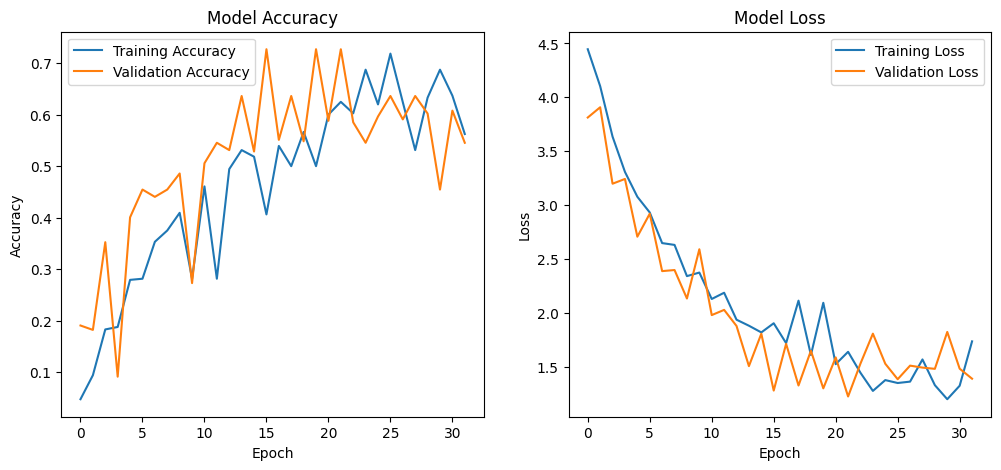

In [25]:
import matplotlib.pyplot as plt

# Plot accuracy and loss curves for training and validation
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')

    plt.show()

# Call the function to plot the history
plot_training_history(history)
